In [14]:
img_path = "imgs/download.jpeg"
result_path = "imgs/download_result.jpeg"

## 显示原图片

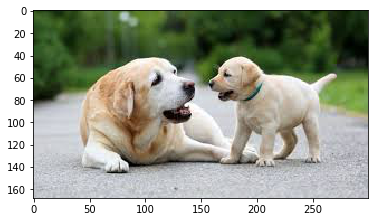

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = plt.imread(img_path)
plt.imshow(img)

## 预测

In [16]:
# -*- coding: utf-8 -*-
"""
@Time          : 2020/08/10 15:07
@Author        : FelixFu
@File          : train.py
@Noice         :
@Modificattion :
    @Author    :
    @Time      :
    @Detail    :
"""
import torch

from models.resnet_yolo import resnet50
import torchvision.transforms as transforms
import cv2
import numpy as np

VOC_CLASSES = (    # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

Color = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128]
]


def decoder(pred):
    """
    pred (tensor)  torch.Size([1, 14, 14, 30])
    return (tensor) box[[x1,y1,x2,y2]] label[...]
    """
    grid_num = 14
    boxes = []
    cls_indexs = []
    probs = []
    cell_size = 1./grid_num
    pred = pred.data  # torch.Size([1, 14, 14, 30])
    pred = pred.squeeze(0)  # torch.Size([14, 14, 30])
    contain1 = pred[:, :, 4].unsqueeze(2)  # torch.Size([14, 14, 1])
    contain2 = pred[:, :, 9].unsqueeze(2)  # torch.Size([14, 14, 1])
    contain = torch.cat((contain1, contain2), 2)    # torch.Size([14, 14, 2])

    mask1 = contain > 0.1  # 大于阈值, torch.Size([14, 14, 2])  content: tensor([False, False])
    mask2 = (contain == contain.max())  # we always select the best contain_prob what ever it>0.9
    mask = (mask1+mask2).gt(0)

    # min_score,min_index = torch.min(contain,2) # 每个cell只选最大概率的那个预测框
    for i in range(grid_num):
        for j in range(grid_num):
            for b in range(2):
                # index = min_index[i,j]
                # mask[i,j,index] = 0
                if mask[i, j, b] == 1:
                    box = pred[i, j, b*5:b*5+4]
                    contain_prob = torch.FloatTensor([pred[i, j, b*5+4]])
                    xy = torch.FloatTensor([j, i])*cell_size  # cell左上角  up left of cell
                    box[:2] = box[:2]*cell_size + xy  # return cxcy relative to image
                    box_xy = torch.FloatTensor(box.size())  # 转换成xy形式 convert[cx,cy,w,h] to [x1,xy1,x2,y2]
                    box_xy[:2] = box[:2] - 0.5*box[2:]
                    box_xy[2:] = box[:2] + 0.5*box[2:]
                    max_prob, cls_index = torch.max(pred[i, j, 10:], 0)
                    if float((contain_prob*max_prob)[0]) > 0.1:
                        boxes.append(box_xy.view(1, 4))
                        cls_indexs.append(cls_index.item())
                        probs.append(contain_prob*max_prob)
    if len(boxes) == 0:
        boxes = torch.zeros((1, 4))
        probs = torch.zeros(1)
        cls_indexs = torch.zeros(1)
    else:
        boxes = torch.cat(boxes, 0)  # (n,4)
        probs = torch.cat(probs, 0)  # (n,)
        cls_indexs = torch.IntTensor(cls_indexs)  # (n,)
    keep = nms(boxes, probs)

    a = boxes[keep]
    b = cls_indexs[keep]
    c = probs[keep]
    return a, b, c


def nms(bboxes,scores,threshold=0.5):
    '''
    bboxes(tensor) [N,4]
    scores(tensor) [N,]
    '''
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    areas = (x2-x1) * (y2-y1)
    # print(scores)   # tensor([0.1006, 0.2381, 0.1185, 0.5342, 0.2892, 0.3521, 0.6027])
    _, order = scores.sort(0, descending=True)
    keep = []
    # print("order:", order)    # order: tensor([6, 3, 5, 4, 1, 2, 0])
    # print("order.numel:", order.numel())  # 7
    while order.numel() > 0:
        if order.numel() == 1:
            # print("end1")
            # print(type(order))
            # print(order)
            i = order
            keep.append(i)
            break
        # print("len:", order.size())
        # print(keep)
        i = order[0]
        keep.append(i)

        xx1 = x1[order[1:]].clamp(min=x1[i])
        yy1 = y1[order[1:]].clamp(min=y1[i])
        xx2 = x2[order[1:]].clamp(max=x2[i])
        yy2 = y2[order[1:]].clamp(max=y2[i])

        w = (xx2-xx1).clamp(min=0)
        h = (yy2-yy1).clamp(min=0)
        inter = w*h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        ids = (ovr <= threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids+1]
    return torch.LongTensor(keep)


# start predict one image
def predict_gpu(model, image_name, root_path=''):
    result = []
    image = cv2.imread(root_path+image_name)
    # print(root_path , image_name)
    h, w, _ = image.shape
    img = cv2.resize(image, (448, 448))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean = (123, 117, 104)  # RGB
    img = img - np.array(mean, dtype=np.float32)

    transform = transforms.Compose([transforms.ToTensor(), ])
    img = transform(img)  # torch.Size([3, 448, 448])
    img = img[None, :, :, :]  # img: torch.Size([1, 3, 448, 448])
    img = img.cuda()

    pred = model(img)  # 1x7x7x30
    pred = pred.cpu()
    boxes, cls_indexs, probs = decoder(pred)

    for i, box in enumerate(boxes):
        x1 = int(box[0]*w)
        x2 = int(box[2]*w)
        y1 = int(box[1]*h)
        y2 = int(box[3]*h)
        cls_index = cls_indexs[i]
        cls_index = int(cls_index)  # convert LongTensor to int
        prob = probs[i]
        prob = float(prob)
        result.append([(x1, y1), (x2, y2), VOC_CLASSES[cls_index], image_name, prob])
    return result


if __name__ == '__main__':
    model = resnet50()
    print('load model...')
    model.load_state_dict(torch.load('checkpoints/best.pth'))
    model.eval()
    model.cuda()
    image_name = img_path
    image = cv2.imread(image_name)
    print('predicting...')
    result = predict_gpu(model, image_name)

    for left_up, right_bottom, class_name, _, prob in result:
        color = Color[VOC_CLASSES.index(class_name)]
        cv2.rectangle(image, left_up, right_bottom, color, 2)
        label = class_name+str(round(prob, 2))
        text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1] - text_size[1])
        cv2.rectangle(image, (p1[0] - 2//2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
        cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

    cv2.imwrite(result_path, image)
    print('predicted!')






load model...
predicting...
predicted!


## 显示结果图片

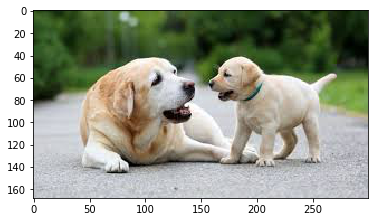

In [17]:
img = plt.imread(img_path)
plt.imshow(img)

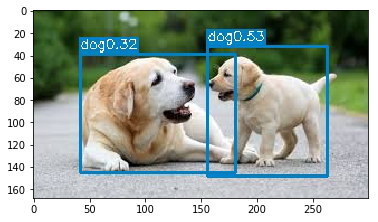

In [18]:
img = plt.imread(result_path)
plt.imshow(img)